# 5LSL0 Assignment 4: Deep Unfolding
---

In [1]:
# Import libraries
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# local imports
import MNIST_dataloader
import Fast_MRI_dataloader

# Set torches random seed
torch.random.manual_seed(0)

# Define parameters
data_loc1 = 'D://5LSL0-Datasets'
data_loc2 = './Fast_MRI_Knee'

## Week 1

### Loading MNIST dataset

Number of training batches: 938
Number of test batches: 157


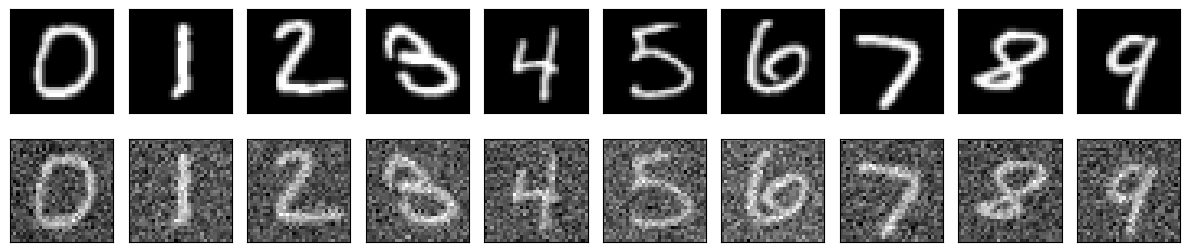

In [2]:
# Define batch size
batch_size = 64

# Create dataloaders
train_loader, test_loader = MNIST_dataloader.create_dataloaders(data_loc1, batch_size)

# Print the number of batches for training and testing
print(f"Number of training batches: {len(train_loader)}"
        f"\nNumber of test batches: {len(test_loader)}")

# Get some examples as the first 10 correspond to the digits 0-9
_, (x_clean_example, x_noisy_example, labels_example) = next(enumerate(test_loader))

# show the examples in a plot
plt.figure(figsize=(12,3))
for i in range(10):
    plt.subplot(2,10,i+1)
    plt.imshow(x_clean_example[i,0,:,:],cmap='gray')
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(2,10,i+11)
    plt.imshow(x_noisy_example[i,0,:,:],cmap='gray')
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()
plt.show()

In [3]:
# Access the entire training and test set for later use
clean_train = train_loader.dataset.Clean_Images # 60000 training images
noisy_train = train_loader.dataset.Noisy_Images
labels_train  = train_loader.dataset.Labels

clean_test  = test_loader.dataset.Clean_Images # 10000 test images
noisy_test  = test_loader.dataset.Noisy_Images
labels_test   = test_loader.dataset.Labels

# Access 10 examples as representations for all digits
clean_example = clean_test[0:10,:,:,:]
noisy_example = noisy_test[0:10,:,:,:]
labels_example = labels_test[0:10]

## Exercise 1 - ISTA

### (a) [3 pt] Create a Python function that implements ISTA for MNIST denoising. 

- Make sure the function takes as inputs: step size `μ`, shrinkage parameter `λ`, number of iteration `K`, and measurements (batch of MNIST images) `y`. 
- It should output the final batch of reconstructions x<sub>K</sub>.

- HINT: The images are normalized between -1 and 1, which means the background of the images is not at zero. Think about how to still aply ISTA correctly.

In [4]:
# Soft thresholding function
def softthreshold(x, shrinkage):
    return torch.sign(x) * torch.max(torch.abs(x) - shrinkage, torch.tensor(0.0))

# ISTA function
def ISTA(mu, shrinkage, K, y):
    # Initialize x to be the same as y
    x = y.clone() 
    
    # Iteratively apply the soft thresholding function
    for _ in tqdm(range(K)):
        # Compute the gradient
        x = x - mu * (x - y)
        # Shrinkage step
        x = softthreshold(x, mu * shrinkage)
    
    # Normalize the final batch of reconstructions to be between -1 and 1
    x = 2 * (x - x.min()) / (x.max() - x.min()) - 1
    
    # Return the final batch of reconstructions
    return x

### (b) [2 pt] Use your ISTA algorithm on 10 example images. 

- Show them in a figure consisting of 10 collumns (1 per digit) and 3 rows. Row 1 should contain the noisy
measurement, row 2 the reconstruction, and row 3 the actual ground truth target.
- You will have to play with the values for `μ`, `λ`, and `K`. 
- Explain what you see.

100%|██████████| 10/10 [00:00<00:00, 5173.04it/s]


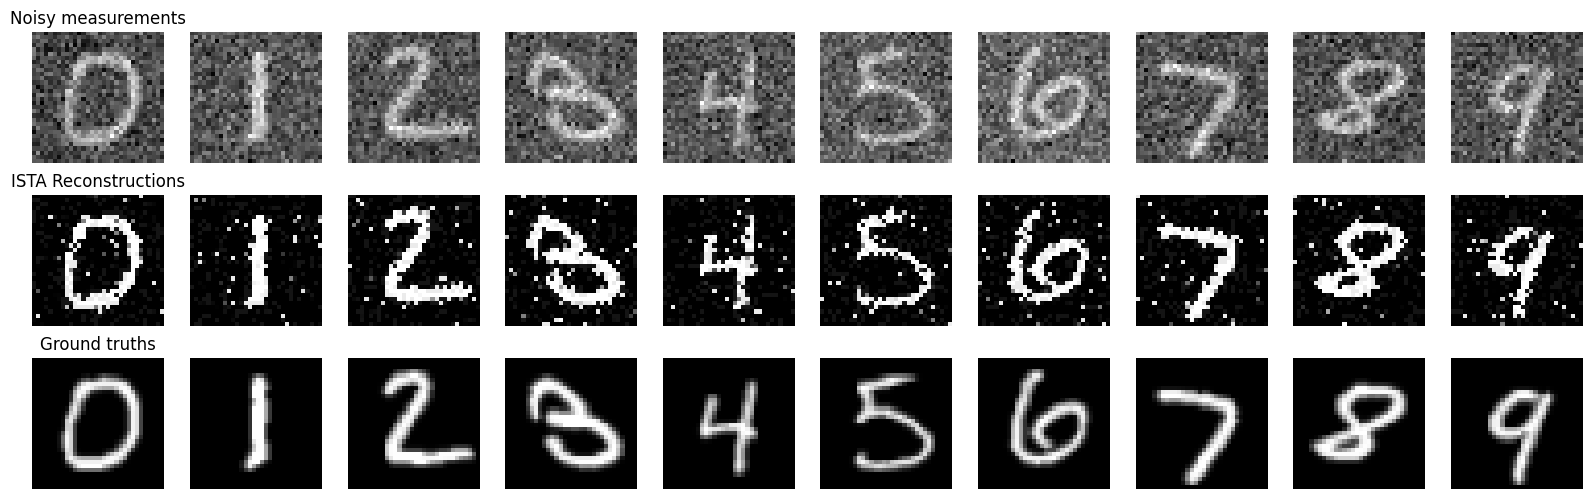

In [5]:
mu = 5.0
shrinkage = 0.01
K = 10

# Apply the ISTA algorithm to the noisy example images
x_reconstructed = ISTA(mu, shrinkage, K, noisy_example)

# Create a figure with 10 columns and 3 rows
fig, axs = plt.subplots(3, 10, figsize=(20, 6))

# For each column
for i in range(10):
    # Display the noisy measurement in the first row
    axs[0, i].imshow(noisy_example[i,0,:,:], cmap='gray')
    axs[0, i].axis('off')
    
    # Display the reconstruction in the second row
    axs[1, i].imshow(x_reconstructed[i,0,:,:], cmap='gray')
    axs[1, i].axis('off')
    
    # Display the ground truth in the third row
    axs[2, i].imshow(clean_example[i,0,:,:], cmap='gray')
    axs[2, i].axis('off')

# Set the titles for the rows
axs[0, 0].set_title('Noisy measurements')
axs[1, 0].set_title('ISTA Reconstructions')
axs[2, 0].set_title('Ground truths')

# Save the figure
plt.savefig('ISTA_Reconstructions.png')

# Display the figure
plt.show()

After playing around with the values for `μ`, `λ`, and `K`, we can observe that the ISTA algorithm did a pretty good job in getting the reconstructions close to the ground truths (clean images). However, it was not possible to remove all the noise and still some noise is visible in the reconstructions.

### (c) [1 pt] get a numerical estimate for the performance of ISTA

- Run it on the entire test set and report the resulting mean squared error (mse).

In [6]:
# Apply the ISTA algorithm to all test images
test_reconstructions = ISTA(mu, shrinkage, K, noisy_test)

# Calculate the MSE over the entire test dataset
mse_test = torch.mean((clean_test - test_reconstructions)**2)

print('Average MSE over test set:', mse_test.item())

100%|██████████| 10/10 [00:02<00:00,  4.64it/s]


Average MSE over test set: 0.13302601873874664


## Exercise 2 - LISTA

### (a) [4 pt] Implement LISTA for 3 unfolded iterations. 

- Train it for at least 10 epochs and plot the loss in terms of either epochs or number of batches seen. 
- Make suitable choices for all the hyper-parameters.

In [7]:
# Check if CUDA is available and set PyTorch to use GPU or CPU accordingly
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda:0


In [8]:
# Define the LISTA layer
class LISTALayer(nn.Module):
    def __init__(self):
        super(LISTALayer, self).__init__()
        self.conv1 = nn.Conv2d(1, 1, 3, padding=1)
        self.conv2 = nn.Conv2d(1, 1, 3, padding=1)
        self.lambda_ = nn.Parameter(torch.rand(1))

    def forward(self, x):
        return x + 0.5 * (torch.sqrt((self.conv1(x) - self.lambda_)**2 + 1) - torch.sqrt((self.conv2(x) + self.lambda_)**2 + 1))

# Define the LISTA model
class LISTAModel(nn.Module):
    def __init__(self):
        super(LISTAModel, self).__init__()
        self.layer1 = LISTALayer()
        self.layer2 = LISTALayer()
        self.layer3 = LISTALayer()

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        return torch.tanh(x)

100%|██████████| 938/938 [00:12<00:00, 76.92it/s] 


Epoch [1/15], Loss: 0.0894


100%|██████████| 938/938 [00:12<00:00, 77.69it/s] 


Epoch [2/15], Loss: 0.0613


100%|██████████| 938/938 [00:13<00:00, 69.53it/s]


Epoch [3/15], Loss: 0.0422


100%|██████████| 938/938 [00:13<00:00, 67.77it/s]


Epoch [4/15], Loss: 0.0338


100%|██████████| 938/938 [00:15<00:00, 61.97it/s]


Epoch [5/15], Loss: 0.0263


100%|██████████| 938/938 [00:12<00:00, 76.73it/s]


Epoch [6/15], Loss: 0.0270


100%|██████████| 938/938 [00:13<00:00, 68.40it/s]


Epoch [7/15], Loss: 0.0228


100%|██████████| 938/938 [00:13<00:00, 68.79it/s]


Epoch [8/15], Loss: 0.0203


100%|██████████| 938/938 [00:17<00:00, 54.44it/s]


Epoch [9/15], Loss: 0.0203


100%|██████████| 938/938 [00:14<00:00, 66.77it/s]


Epoch [10/15], Loss: 0.0212


100%|██████████| 938/938 [00:14<00:00, 63.36it/s]


Epoch [11/15], Loss: 0.0207


100%|██████████| 938/938 [00:13<00:00, 69.57it/s]


Epoch [12/15], Loss: 0.0200


100%|██████████| 938/938 [00:13<00:00, 68.98it/s]


Epoch [13/15], Loss: 0.0172


100%|██████████| 938/938 [00:13<00:00, 69.58it/s]


Epoch [14/15], Loss: 0.0189


100%|██████████| 938/938 [00:14<00:00, 66.46it/s]


Epoch [15/15], Loss: 0.0189


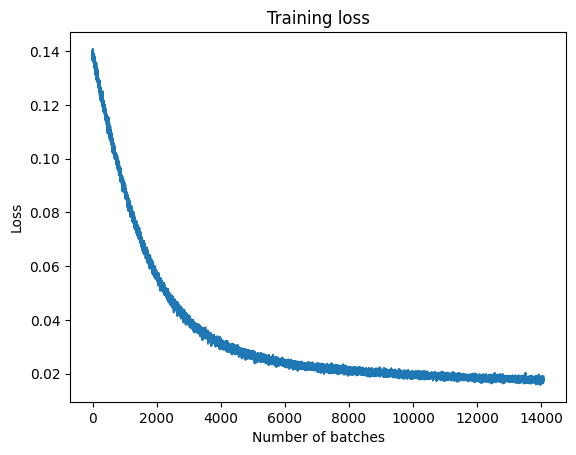

In [9]:
# Create the model and move it to GPU if available
model = LISTAModel().to(device)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=3e-5)

# Train the LISTA model
num_epochs = 15
losses = []
for epoch in range(num_epochs):
    for i, (clean, noisy, _) in enumerate(tqdm(train_loader)):
        # Move data to GPU if available
        noisy, clean = noisy.to(device), clean.to(device)

        # Forward pass
        outputs = model(noisy)
        loss = criterion(outputs, clean)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Record the loss
        losses.append(loss.item())

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Plot the loss
plt.plot(losses)
plt.xlabel('Number of batches')
plt.ylabel('Loss')
plt.title('Training loss')

# Save the figure
plt.savefig('LISTA_Training_Loss.png')
plt.show()

### (b) [2 pt] Repeat exercise 1b using your trained LISTA.

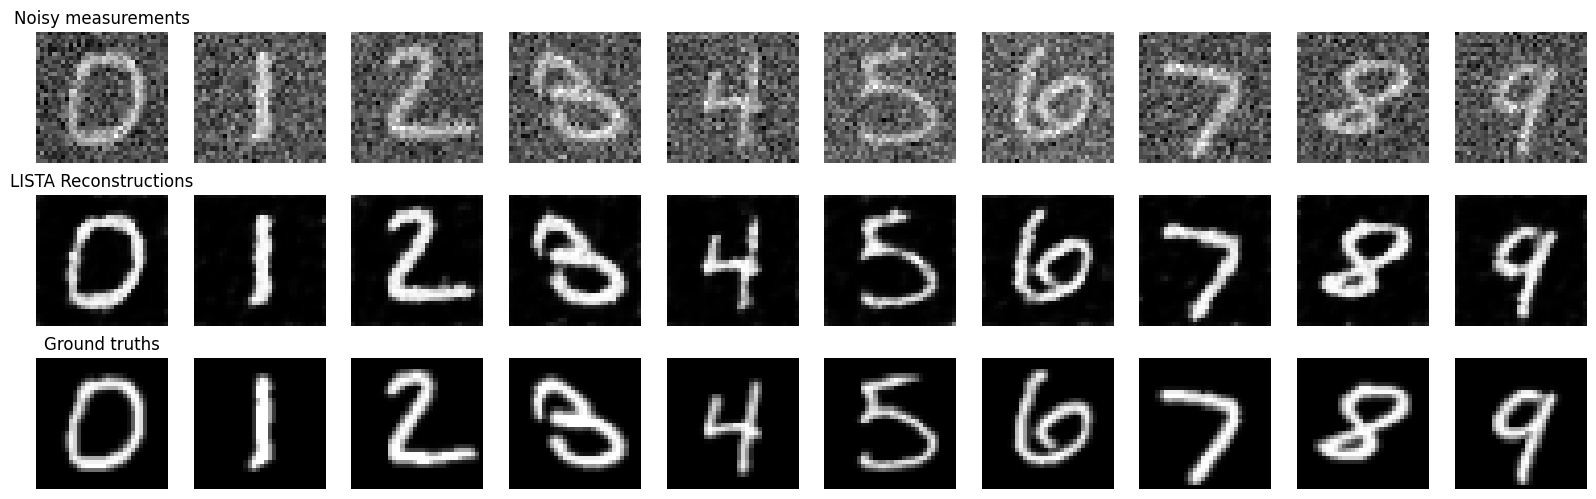

In [10]:
# Get a batch of test data
clean, noisy, label = next(iter(test_loader)) 

output = model(noisy.to(device)) # Move the noisy data to the GPU and get the output
output = output.detach().cpu() # Move the output back to the CPU

# Access 10 examples as representations for all digits
clean_example = clean[0:10,:,:,:]
noisy_example = noisy[0:10,:,:,:]
output_example = output[0:10,:,:,:]

# Create a figure with 10 columns and 3 rows
fig, axs = plt.subplots(3, 10, figsize=(20, 6))

# For each column
for i in range(10):
    # Display the noisy measurement in the first row
    axs[0, i].imshow(noisy_example[i,0,:,:], cmap='gray')
    axs[0, i].axis('off')
    
    # Display the reconstruction in the second row
    axs[1, i].imshow(output_example[i,0,:,:], cmap='gray')
    axs[1, i].axis('off')
    
    # Display the ground truth in the third row
    axs[2, i].imshow(clean_example[i,0,:,:], cmap='gray')
    axs[2, i].axis('off')

# Set the titles for the rows
axs[0, 0].set_title('Noisy measurements')
axs[1, 0].set_title('LISTA Reconstructions')
axs[2, 0].set_title('Ground truths')

# Save the figure
plt.savefig('LISTA_Reconstructions.png')

# Display the figure
plt.show()

Based on the results we can observe that the trained LISTA performs really good in denoising the MNIST images to match the ground truths.

### (c) [1 pt] Repeat exercise 1c using your trained LISTA.

In [11]:
model.eval() # Set the model to evaluation mode

# Apply the LISTA model to all test images
loss = []

for batch, (clean, noisy, _) in enumerate(test_loader):
    # Move data to GPU if available
    clean, noisy = clean.to(device), noisy.to(device)

    # Forward pass
    output = model(noisy)
    x = criterion(output, clean).item()
    loss.append(x)

print(f"Average MSE over test set: {np.mean(loss)}")


Average MSE over test set: 0.017426176115301003


### (d) [1 pt] As you know, neural networks need non-linear activation functions to learn a smarter mapping than just a linear one. 
- Where is/are the non-linear activation functions in LISTA, if there even are any?

Answer: The non-linearity in the LISTA model comes from the shrinkage-thresholding operation, which is inherently non-linear. The `torch.sqrt` function introduces non-linearity. The square root function is non-linear because the rate of change of its output is not constant. The subtraction and addition operations with `self.lambda_` also contribute to the non-linearity.

So, even though there's no traditional non-linear activation function like ReLU or sigmoid, the LISTA model still has non-linear characteristics due to the shrinkage-thresholding operation.

---

## Week 2

In [13]:
# Define parameters
batch_size = 2

# Create dataloaders 
train_loader, test_loader = Fast_MRI_dataloader.create_dataloaders(data_loc2, batch_size)

# Go over the dataset
for i,(kspace, M, gt) in enumerate(tqdm(test_loader)):
    continue

# %% plot the last example
kspace_plot_friendly = torch.log(torch.abs(kspace[0,:,:])+1e-20)

plt.figure(figsize = (10,10))
plt.subplot(1,3,1)
plt.imshow(kspace_plot_friendly,vmin=-2.3,interpolation='nearest')
plt.xticks([])
plt.yticks([])
plt.title('partial k-space')

plt.subplot(1,3,2)
plt.imshow(M[0,:,:],interpolation='nearest')
plt.xticks([])
plt.yticks([])
plt.title('measurement mask')

plt.subplot(1,3,3)
plt.imshow(gt[0,:,:],cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title('ground truth')

plt.savefig("Fast_MRI_Example",dpi=300,bbox_inches='tight')
plt.close()

  0%|          | 0/123 [00:00<?, ?it/s]

100%|██████████| 123/123 [00:07<00:00, 17.51it/s]
